In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import StackingClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Palette
sns.set_palette("icefire")

# Load and Overview


In [32]:
train = pd.read_csv("/kaggle/input/playground-series-s5e11/train.csv", index_col=0)
test = pd.read_csv("/kaggle/input/playground-series-s5e11/test.csv", index_col=0)
# orig = pd.read_csv("/kaggle/input/loan-prediction-dataset-2025/loan_dataset_20000.csv")

for col in train.select_dtypes(include="object").columns:
            train[col] = train[col].astype("category")
    
print(
    "Missing Train: ",
    train.isnull().sum().sum(),
    " - Missing Test: ",
    test.isnull().sum().sum(),
    end="\n\n",
)
train.head(3)

Missing Train:  0  - Missing Test:  0



,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
id,,,,,,,,,,,,
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0


In [33]:
train.describe(include="all")

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994,593994,593994,593994,593994,593994,593994.000000
unique,NaN,NaN,NaN,NaN,NaN,3,4,5,5,8,30,NaN
top,NaN,NaN,NaN,NaN,NaN,Female,Single,Bachelor's,Employed,Debt consolidation,C3,NaN
freq,NaN,NaN,NaN,NaN,NaN,306175,288843,279606,450645,324695,58695,NaN
mean,48212.202976,0.120696,680.916009,15020.297629,12.356345,NaN,NaN,NaN,NaN,NaN,NaN,0.798820
std,26711.942078,0.068573,55.424956,6926.530568,2.008959,NaN,NaN,NaN,NaN,NaN,NaN,0.400883
min,6002.430000,0.011000,395.000000,500.090000,3.200000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,27934.400000,0.072000,646.000000,10279.620000,10.990000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
50%,46557.680000,0.096000,682.000000,15000.220000,12.370000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,60981.320000,0.156000,719.000000,18858.580000,13.680000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


# Distribution

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 593994 entries, 0 to 593993
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   annual_income         593994 non-null  float64 
 1   debt_to_income_ratio  593994 non-null  float64 
 2   credit_score          593994 non-null  int64   
 3   loan_amount           593994 non-null  float64 
 4   interest_rate         593994 non-null  float64 
 5   gender                593994 non-null  category
 6   marital_status        593994 non-null  category
 7   education_level       593994 non-null  category
 8   employment_status     593994 non-null  category
 9   loan_purpose          593994 non-null  category
 10  grade_subgrade        593994 non-null  category
 11  loan_paid_back        593994 non-null  float64 
dtypes: category(6), float64(5), int64(1)
memory usage: 35.1 MB


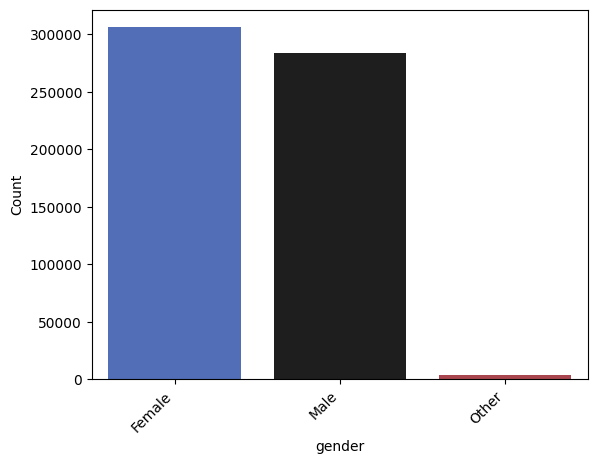

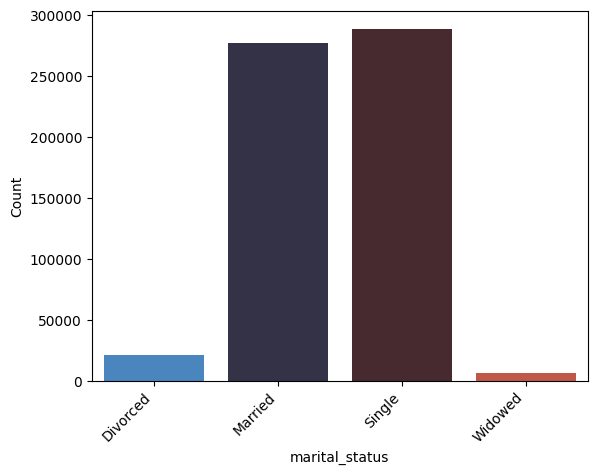

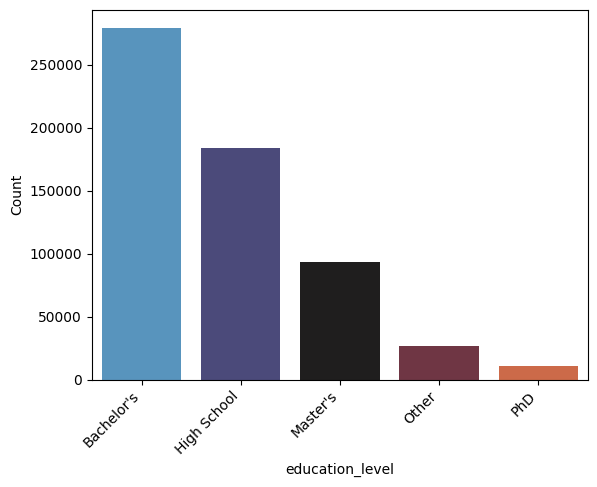

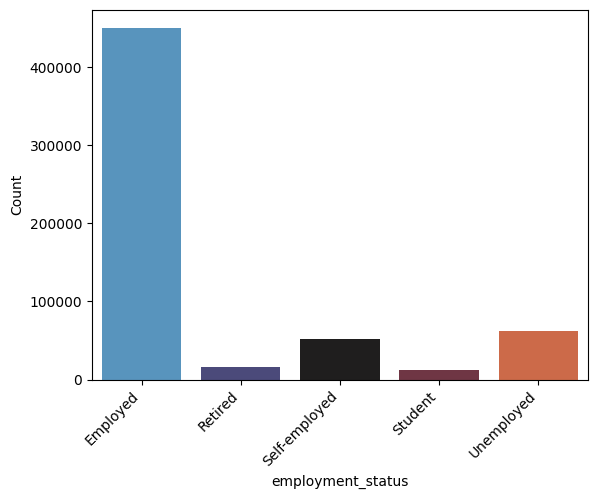

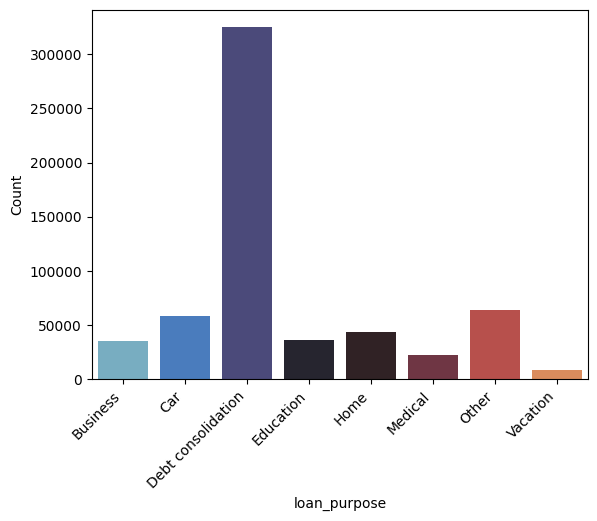

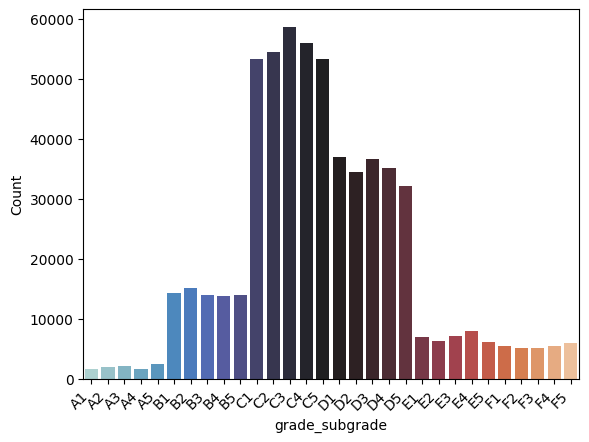

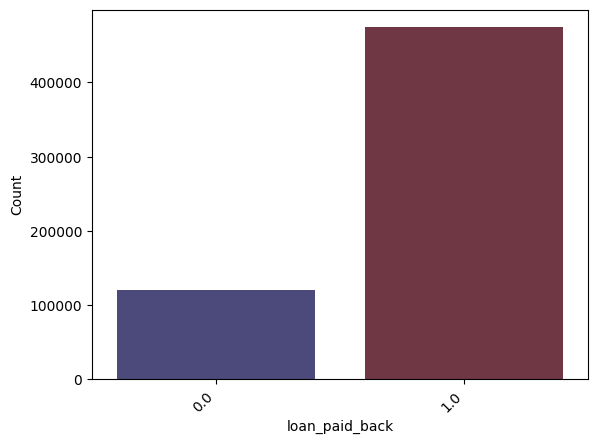

In [35]:
for col in train.select_dtypes(include="category").columns.to_list() + ["loan_paid_back"]:
    sns.countplot(data=train, x=train[col], palette="icefire")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

In [36]:
class Features(BaseEstimator, TransformerMixin):
    def __init__(self):
        self

    def fit(self, df, y=None):
        df = df.copy()

        return self

    def transform(self, df):
        df = df.copy()

        df["annual_incomeXcredit_score"] = df["annual_income"] * df["credit_score"]

        return df

In [37]:
X = train.iloc[:, :-1]
y = train.iloc[:, -1]
X_pred = test

catFeatures = (
    Features().fit_transform(X, y).select_dtypes(include="category").columns.to_list()
)
catFeatures

['gender',
 'marital_status',
 'education_level',
 'employment_status',
 'loan_purpose',
 'grade_subgrade']

In [44]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

xgb = Pipeline([
    ("feature", Features()),
    ("xgb",XGBClassifier(
        random_state=42,
        n_estimators=500,
        learning_rate=0.03,
        enable_categorical=True,
        verbose=False,
        device="cuda",
        n_job=-1,
    )),
])

cat = Pipeline([
    ("feature", Features()),
    ("cat", CatBoostClassifier(
        random_state=42,
        n_estimators=500,
        learning_rate=0.03,
        cat_features=catFeatures,
        verbose=False,
    )),
])

lgb = Pipeline([
    ("feature", Features()),
    ("lgb", LGBMClassifier(
        random_state=42, 
        n_estimators=500, 
        learning_rate=0.03, 
        verbose=-1,
    )),
])

In [39]:
score_xgb = cross_val_score(xgb, X, y, cv=cv, scoring="roc_auc")
print(
    f"xgb scores across folds: {score_xgb} - Mean Score: {score_xgb.mean():0.4f}"
)

score_cat = cross_val_score(cat, X, y, cv=cv, scoring="roc_auc")
print(
    f"cat scores across folds: {score_cat} - Mean Score: {score_cat.mean():0.4f}"
)

score_lgb = cross_val_score(lgb, X, y, cv=cv, scoring="roc_auc")
print(
    f"lgb scores across folds: {score_lgb} - Mean Score: {score_lgb.mean():0.4f}",
    end="\n\n",
)

score_xgb = np.mean([score_xgb, score_cat, score_lgb], axis=0)
print(f"Overall Performance: {score_xgb.mean()}")

XGB_all scores across folds: [0.9206975  0.91990628 0.91805266 0.91905189 0.91862793] - Mean Score: 0.9193
XGB_int scores across folds: [0.91814815 0.91785007 0.91613574 0.91698018 0.9169738 ] - Mean Score: 0.9172
XGB_cat scores across folds: [0.92147296 0.9206218  0.91936077 0.92042509 0.91962376] - Mean Score: 0.9203

Overall Performance XGB: 0.9189285718294696


In [42]:
total = 0.9193 + 0.9172 + 0.9203
xgb_weight = 0.9193 / total * 100
cat_weight = 0.9172 / total * 100
lgb_weight = 0.9203 / total * 100
print(xgb, cat, lgb)

33.34663377829367 33.270458502611724 33.382907719094604


In [45]:
xgb.fit(X, y)
cat.fit(X, y)
lgb.fit(X, y)

Pipeline(steps=[('feature', Features()),
                ('lgb',
                 LGBMClassifier(learning_rate=0.03, n_estimators=500,
                                random_state=42, verbose=-1))])

In [53]:
importantFeatures = pd.DataFrame(
    data={
        "xgb": xgb.named_steps["xgb"].feature_importances_ / xgb.named_steps["xgb"].feature_importances_.max(),
        "cat": cat.named_steps["cat"].feature_importances_ / cat.named_steps["cat"].feature_importances_.max(),
        "lgb": lgb.named_steps["lgb"].feature_importances_ / lgb.named_steps["lgb"].feature_importances_.max(),
    },
    index = Features().fit_transform(X, y).columns
)
importantFeatures["Overall"] = importantFeatures.mean(axis=1)
importantFeatures.sort_values("Overall", ascending=False)

,xgb,cat,lgb,Overall
employment_status,1.000000,1.000000,0.173356,0.724452
debt_to_income_ratio,0.066405,0.490043,1.000000,0.518816
credit_score,0.056484,0.430446,0.446674,0.311201
grade_subgrade,0.014553,0.009854,0.302943,0.109117
loan_amount,0.004373,0.011278,0.310206,0.108619
interest_rate,0.003286,0.008905,0.209862,0.074018
annual_income,0.003780,0.005494,0.203173,0.070816
annual_incomeXcredit_score,0.002904,0.003478,0.116590,0.040991
loan_purpose,0.003160,0.003307,0.048739,0.018402
education_level,0.003630,0.003806,0.027905,0.011780
